In [49]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers
from sklearn.decomposition import PCA
from sklearn.cluster import *

In [2]:
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location, 'labelled')

reading outlooks
reading pph
reading storm reports


# Preprocessing

In [166]:
category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}


season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Great Plains': 1,
    'Midwest': 2,
    'Northeast': 3,
    'South': 4
}

tor_dict = {
    'NONE': -1,
    'EFU': 0,
    '(E)F0': 1,
    '(E)F1': 2,
    '(E)F2': 3,
    '(E)F3': 4,
    '(E)F4': 5,
    '(E)F5': 6
}

cats = ['MAX_CAT', 'SEASON', 'TOR_F']
dicts = [category_dict, season_dict, tor_dict]

In [167]:
# remove unneeded variables and x, y dimensions
data = pph.drop(['lat', 'lon', 'p_perfect_wind', 'p_perfect_sig_wind', 'p_perfect_hail', 'p_perfect_sig_hail', 'p_perfect_tor', 'p_perfect_sig_tor', 'RAMP_CAT', 'p_perfect_total', 'p_perfect_max', 'PPH_CAT', 'PPH_NUM', 'PPH_D_CAT', 'WINDSP_CAT', 'HAILSZ_CAT', 'REGION', 'REGION_M'])


# make data numerical
def convert_strings_to_ints(data, conversion_dict):
    return np.vectorize(conversion_dict.get)(data)

for cat, dic in zip(cats, dicts):

    data[cat] = xr.apply_ufunc(
        convert_strings_to_ints,  # function to apply
        data[cat],      # input data
        kwargs={'conversion_dict': dic},  # additional arguments
        vectorize=True            # vectorize the function
    )

In [156]:
# consolidate dates 
earliest_date = max(min(outlooks['DATE']), min(pph['time']), min(reports['DATE'])) #TODO first two days of outlook dataset don't have day 3 forecast. but probably ok since not mdt
latest_date = min(max(outlooks['DATE']), max(pph['time']), max(reports['DATE']))

In [179]:
earliest_date = '200203300000'
all_pph_dates = data['time']
pph_dates = all_pph_dates[all_pph_dates <= latest_date]
pph_dates = pph_dates[pph_dates >= earliest_date]
new_data = data.sel(time = pph_dates)

In [188]:
# pick subset
new_data = new_data.where(new_data['MAX_CAT'] >= 4, drop = True)

In [189]:
def standardize_dataset(dataset):
    standardized_data = {}
    means = []
    stds = []

    for var in dataset.data_vars:
        data_array = dataset[var]
        mean = data_array.values.mean()
        means.append(mean)
        std = data_array.values.std()
        stds.append(std)
        standardized_data[var] = (data_array - mean) / std
    return xr.Dataset(standardized_data), means, stds

def unstandardize_dataset(data, means, stds):
    var_names = list(new_data.keys())
    for i, var in zip(range(len(var_names)), var_names):
        data[var] = data[var] * stds[i] + means[i]
    return data

new_data, means, stds = standardize_dataset(new_data)

# PCA

In [191]:
# do pca
data_matrix = new_data.to_array(dim = 'time').data.T
pca = PCA()

pca.fit(data_matrix)

PCA()

PC 0
MAX_CAT: 0.11494957792861979
RAMP_UP: 0.012303176054249909
RAMP_DOWN: 0.04739367563333574
SEASON: 0.009616918005000391
REPORT_NUM: 0.39143250851516975
TOR_NUM: 0.23043701520281606
WIND_NUM: 0.3531211096664485
HAIL_NUM: 0.23504931654433653
TOR_F: 0.16191693110741823
WINDSP_NUM: 0.22671364645366388
HAILSZ_NUM: 0.1594972371844417
NEIGH_NUM: 0.3534887444712136
RMSE_NUM: 0.3385454020572912
BS_NUM: 0.36463305538841007
LAT_NUM: 0.05078817846796373
LON_NUM: 0.09095645219043437
PPH_D_NUM: 0.33406684059469344
PC 1
MAX_CAT: -0.32945544943546523
RAMP_UP: -0.11987051102947682
RAMP_DOWN: -0.1308831506788802
SEASON: 0.23453519835082792
REPORT_NUM: -0.006844513671856123
TOR_NUM: -0.3471070530863267
WIND_NUM: 0.2402271376929873
HAIL_NUM: -0.29749681824763385
TOR_F: -0.4229568163721896
WINDSP_NUM: -0.0971757319581136
HAILSZ_NUM: -0.36063309885858263
NEIGH_NUM: 0.1845878075575752
RMSE_NUM: 0.25485955934676774
BS_NUM: 0.16599032094802346
LAT_NUM: 0.09999716445959293
LON_NUM: 0.28446821665679267
PPH_D

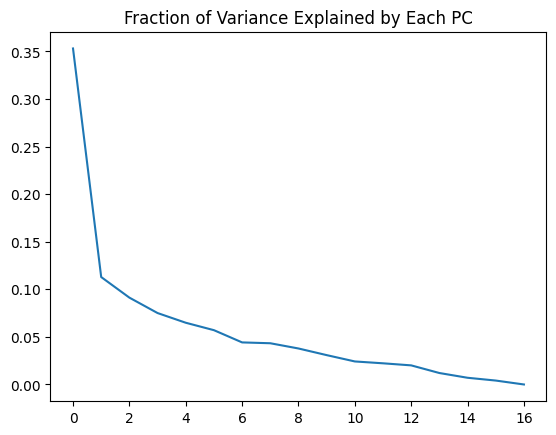

In [192]:
# Print variance expained and componenets of first PCs
plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_))
plt.title('Fraction of Variance Explained by Each PC')
keys = list(new_data.keys())
for i in range(6):
    print('PC ' + str(i))
    pc = pca.components_[i, :]
    for j in range(len(pc)):
        print(keys[j] + ': ' + str(pc[j]))
    

# Clustering

In [197]:
# cluster with, k-means, knn, optics, birch, dbscan look here for use cases https://scikit-learn.org/stable/modules/clustering.html
# Will want to come up with way to visualize: put location on map, color code by other value(s)? Then do similar for many clustering methods
X = data_matrix
km = sklearn.cluster.KMeans().fit(X)
centers = (km.cluster_centers_ * stds + means)


def plot_clusters(centers, keys, sizekey = None, shapekey = None, colorkey = None, edgekey = None, save = False, show = True, save_location = 'plots'):
    fig=plt.figure(figsize=(9,6))
    plt.style.use('dark_background')
    ax = plt.axes(projection = cp.crs.LambertConformal())
    ax.add_feature(cp.feature.LAND,facecolor='grey')
    ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
    ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
    ax.add_feature(cp.feature.LAKES, alpha = 0.5)
    ax.add_feature(cp.feature.STATES,linewidth=0.5)

    lats = []
    lons = []
    sizes = [] # pick a scale
    shapes = [] # will do pointier for higher numbers
    colors = [] # pick a scale
    edges = [] # pick a scale

    for i in range(centers.shape[0]):
        print('Cluster ' + str(i))
        center = centers[i, :]
        for j in range(len(center)):
            keyj = keys[j]
            centerj = center[j]
            print(keyj + ': ' + str(centerj))
            if keyj == 'LAT_NUM':
                lats.append(centerj)
            elif keyj == 'LON_NUM':
                lons.append(centerj)
            elif keyj == sizekey:
                sizes.append(centerj)
            elif keyj == shapekey:
                shapes.append(centerj)
            elif keyj == colorkey:
                colors.append(centerj)
            elif keyj == edgekey:
                edges.append(centerj)

    ax.scatter(lons, lats, transform=cp.crs.PlateCarree(), c = colors, s = sizes)
    
    # build the plot, save and show
        
    
# do each 


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0
MAX_CAT: 4.0
RAMP_UP: 1.8775510204081634
RAMP_DOWN: -0.06122448979591845
SEASON: 1.836734693877551
REPORT_NUM: 411.79591836734687
TOR_NUM: 14.081632653061227
WIND_NUM: 284.1020408163265
HAIL_NUM: 113.61224489795917
TOR_F: 2.3265306122448983
WINDSP_NUM: 82.08081632653061
HAILSZ_NUM: 3.474489795918367
NEIGH_NUM: 0.0027210547365506994
RMSE_NUM: 0.02772763799167035
BS_NUM: 0.011456903158285646
LAT_NUM: 39.11157553536551
LON_NUM: -88.44786289760044
PPH_D_NUM: 80.38942822658882
Cluster 1
MAX_CAT: 4.0
RAMP_UP: 1.925925925925926
RAMP_DOWN: -0.01234567901234579
SEASON: 1.0617283950617282
REPORT_NUM: 158.4691358024691
TOR_NUM: 16.938271604938272
WIND_NUM: 53.01234567901237
HAIL_NUM: 88.51851851851852
TOR_F: 2.6049382716049383
WINDSP_NUM: 74.84320987654321
HAILSZ_NUM: 3.583333333333333
NEIGH_NUM: 0.000745222474895077
RMSE_NUM: 0.013111046554710643
BS_NUM: 0.005286752851555719
LAT_NUM: 36.21627261314863
LON_NUM: -96.32474564917294
PPH_D_NUM: 54.60734899017973
Cluster 2
MAX_CAT: 5.0
RAMP_

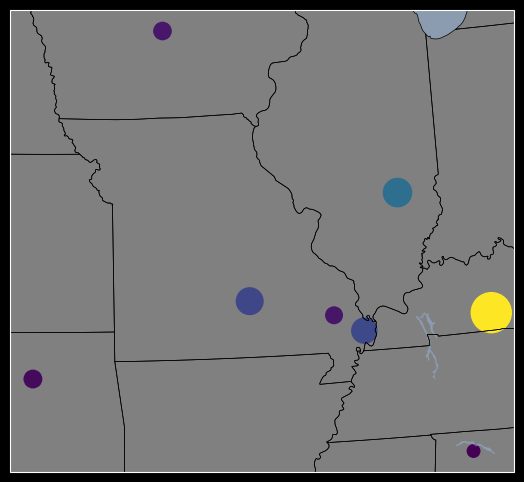

In [198]:
plot_clusters(centers, keys, sizekey='REPORT_NUM', colorkey= 'NEIGH_NUM')